In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import sys
import os
notebook_dir = os.path.abspath('')

# Get the parent directory (which should contain both 'notebooks' and 'shapes')
parent_dir = os.path.dirname(notebook_dir)

# Add the parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

sys.path.append('../shapes')
# Now try to import



In [3]:
from shape_generator import draw_random_shape
from augmentations import random_augment,add_high_frequency_noise
from data_loaders import get_shape_loaders
from model import ResNet18, LinearProbe
import torch
import torch.nn as nn
import umap



In [4]:
train_loader, test_loader = get_shape_loaders(num_train=500, num_test=500, batch_size=64)
shapes = ['circle','triangle','square','rectangle','ellipse']


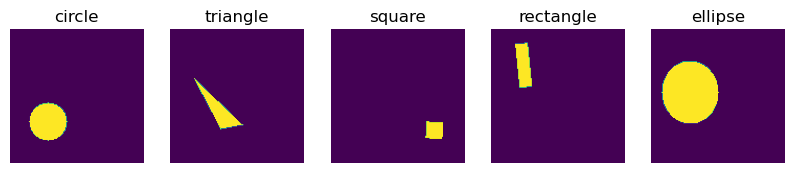

In [5]:
fig,axes = plt.subplots(1,5,figsize=(10,2))
for shape in shapes:
    matrix = np.zeros((128,128))
    matrix = draw_random_shape(matrix,shape = shape)
    axes[shapes.index(shape)].imshow(matrix)
    axes[shapes.index(shape)].set_title(shape)
    axes[shapes.index(shape)].axis('off')

In [6]:
model = ResNet18(num_classes=5)
num_epochs = 100

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer


In [78]:
#training - should be reorganised into a function 

train_loader, test_loader = get_shape_loaders(num_train=500, num_test=500, batch_size=64)
shapes = ['circle','triangle','square','rectangle','ellipse']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
bbox_criterion = nn.MSELoss()


#linear probe to learn features e.g. size
linear_probe = LinearProbe(input_dim=10, output_dim=1) 
linear_probe = linear_probe.to(device)
inter_optimizer = torch.optim.Adam(linear_probe.parameters(), lr=0.001)
inter_criterion = nn.MSELoss()
losses = []
for epoch in range(num_epochs):
    for images, labels,bbox in train_loader:
        #labels[labels==4] = 0
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        bbox = bbox.to(device)
        # Forward pass
        intermediate, outputs,pred_bbox = model(images)
        
        loss = criterion(outputs, labels)
        bbox_loss = bbox_criterion(pred_bbox,bbox)
        combined_loss = loss + bbox_loss
        combined_loss.backward()
        
        optimizer.step()
        #intermediate predict
        inter_optimizer.zero_grad()
        intermediate = intermediate.detach()
        inter_outputs = linear_probe(intermediate)
        #no longer exact size, but from the bbox
        size = bbox[:,2]*bbox[:,3]
        size = size.view(-1, 1)
        inter_loss = inter_criterion(inter_outputs, size)
        inter_loss.backward()
        inter_optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Bbox Loss: {bbox_loss.item():.4f},Size Loss: {inter_loss.item():.4f}')
        # Backward pass and optimize
    #print(np.corrcoef(size.cpu().detach().numpy(),inter_outputs.cpu().detach().numpy().flatten())[0,1])
    losses.append(loss.item())


Epoch [1/100], Loss: 0.7789, Bbox Loss: 0.0036,Size Loss: 2.0910
Epoch [2/100], Loss: 0.7636, Bbox Loss: 0.0034,Size Loss: 1.8575
Epoch [3/100], Loss: 0.7586, Bbox Loss: 0.0036,Size Loss: 1.9118
Epoch [4/100], Loss: 0.7542, Bbox Loss: 0.0031,Size Loss: 1.4602
Epoch [5/100], Loss: 0.7746, Bbox Loss: 0.0029,Size Loss: 1.8174
Epoch [6/100], Loss: 0.8126, Bbox Loss: 0.0018,Size Loss: 1.8587
Epoch [7/100], Loss: 0.8192, Bbox Loss: 0.0020,Size Loss: 1.5993
Epoch [8/100], Loss: 0.6869, Bbox Loss: 0.0021,Size Loss: 1.5214
Epoch [9/100], Loss: 0.6223, Bbox Loss: 0.0029,Size Loss: 1.4026
Epoch [10/100], Loss: 0.6783, Bbox Loss: 0.0020,Size Loss: 1.7323
Epoch [11/100], Loss: 0.6173, Bbox Loss: 0.0026,Size Loss: 1.4448
Epoch [12/100], Loss: 0.6586, Bbox Loss: 0.0019,Size Loss: 1.5605
Epoch [13/100], Loss: 0.7174, Bbox Loss: 0.0023,Size Loss: 1.2531
Epoch [14/100], Loss: 0.6673, Bbox Loss: 0.0015,Size Loss: 1.0434
Epoch [15/100], Loss: 0.6562, Bbox Loss: 0.0020,Size Loss: 0.8505
Epoch [16/100], Los

RuntimeError: Could not infer dtype of NoneType

0.9359025214145874

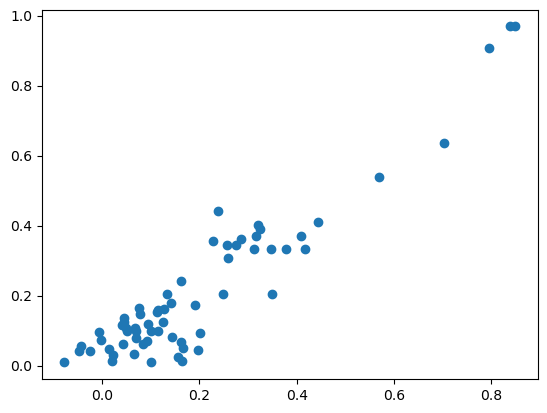

In [79]:
plt.scatter(inter_outputs.cpu().detach().numpy(),size.cpu().detach().numpy())
np.corrcoef(size.cpu().detach().numpy().ravel(),
            inter_outputs.cpu().detach().numpy().flatten())[0,1]

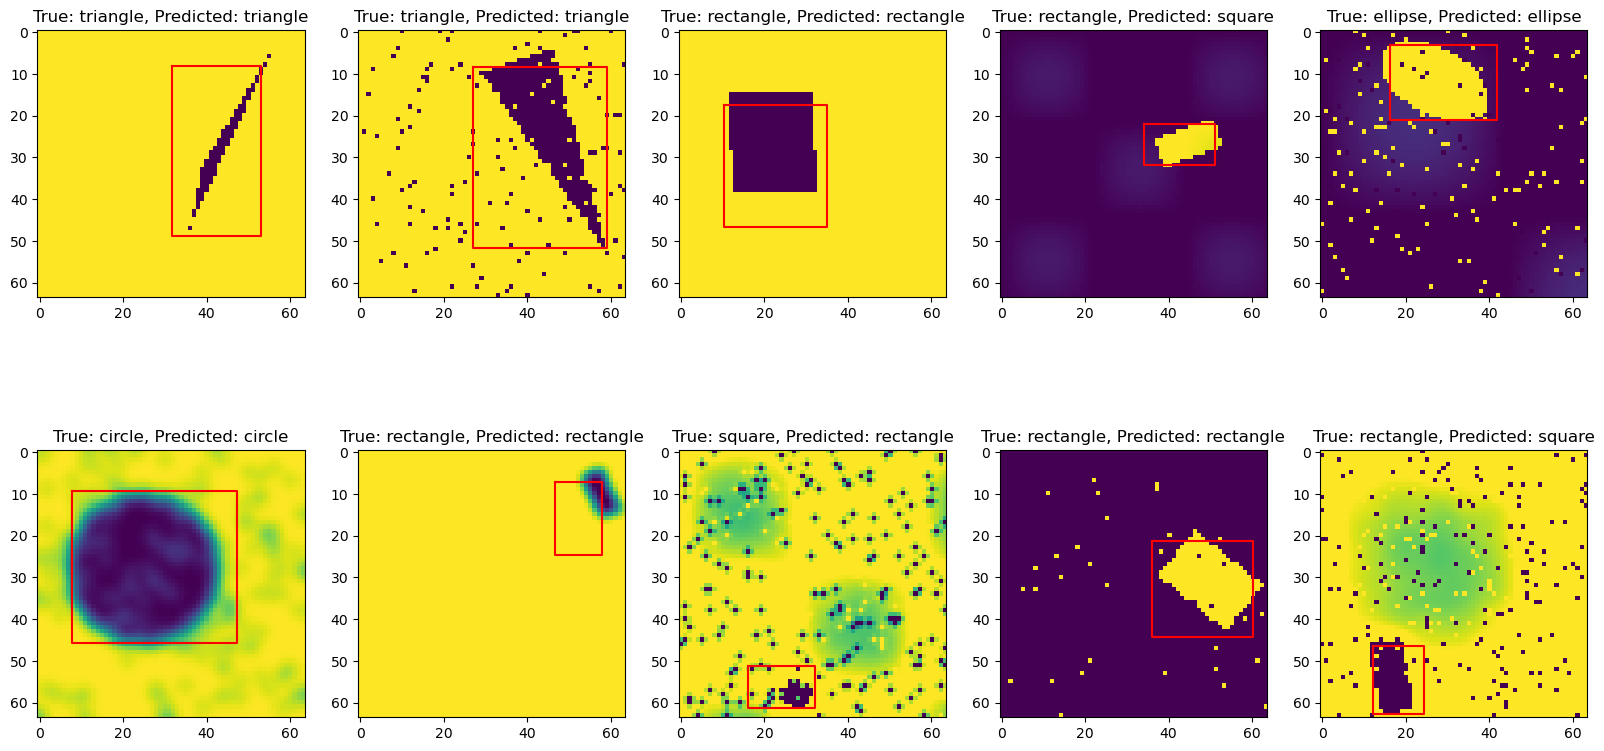

In [80]:
fig, axes = plt.subplots(2,5,figsize=(20,10))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(images[i].cpu().numpy().transpose(1,2,0))
    output = outputs[i].cpu().detach().numpy()
    axes[i].set_title(f"True: {shapes[labels[i].item()]}, Predicted: {shapes[np.argmax(output)]}")
    #plot bbox
    bboxes = pred_bbox[i].cpu().detach().numpy()
    x1,y1,dx,dy = bboxes*64
    vertices = [(x1,y1),(x1+dx,y1),(x1+dx,y1+dy),(x1,y1+dy),(x1,y1)]
    axes[i].plot([v[0] for v in vertices],[v[1] for v in vertices],color='red')

In [97]:
stored_labels = []
stored_intermediate = []
stored_outputs = []
stored_sizes = []
predicted_sizes = []
stored_bbox = []
stored_images = []
for images, labels,bbox in test_loader:
    images, labels, bbox = images.to(device), labels.to(device),bbox.to(device)
    stored_images.append(images.cpu().detach().numpy())
    intermediate, outputs, pred_bbox = model(images)
    predictions = linear_probe(intermediate)
    intermediate = intermediate.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    pred_bbox = pred_bbox.cpu().detach().numpy()
    stored_bbox.append(pred_bbox)
    stored_labels.append(labels)
    stored_intermediate.append(intermediate)
    stored_outputs.append(outputs)
    stored_sizes.append((bbox[:,2]*bbox[:,3]).cpu().detach().numpy())    
    predicted_sizes.append(predictions.cpu().detach().numpy())

In [98]:
stored_labels = np.concatenate(stored_labels)
stored_intermediate = np.concatenate(stored_intermediate)
stored_outputs = np.concatenate(stored_outputs)
stored_sizes = np.concatenate(stored_sizes)
predicted_sizes = np.concatenate(predicted_sizes)
stored_bbox = np.concatenate(stored_bbox)
stored_images = np.concatenate(stored_images)
print(np.mean(stored_labels==np.argmax(stored_outputs,axis=1)))

0.754


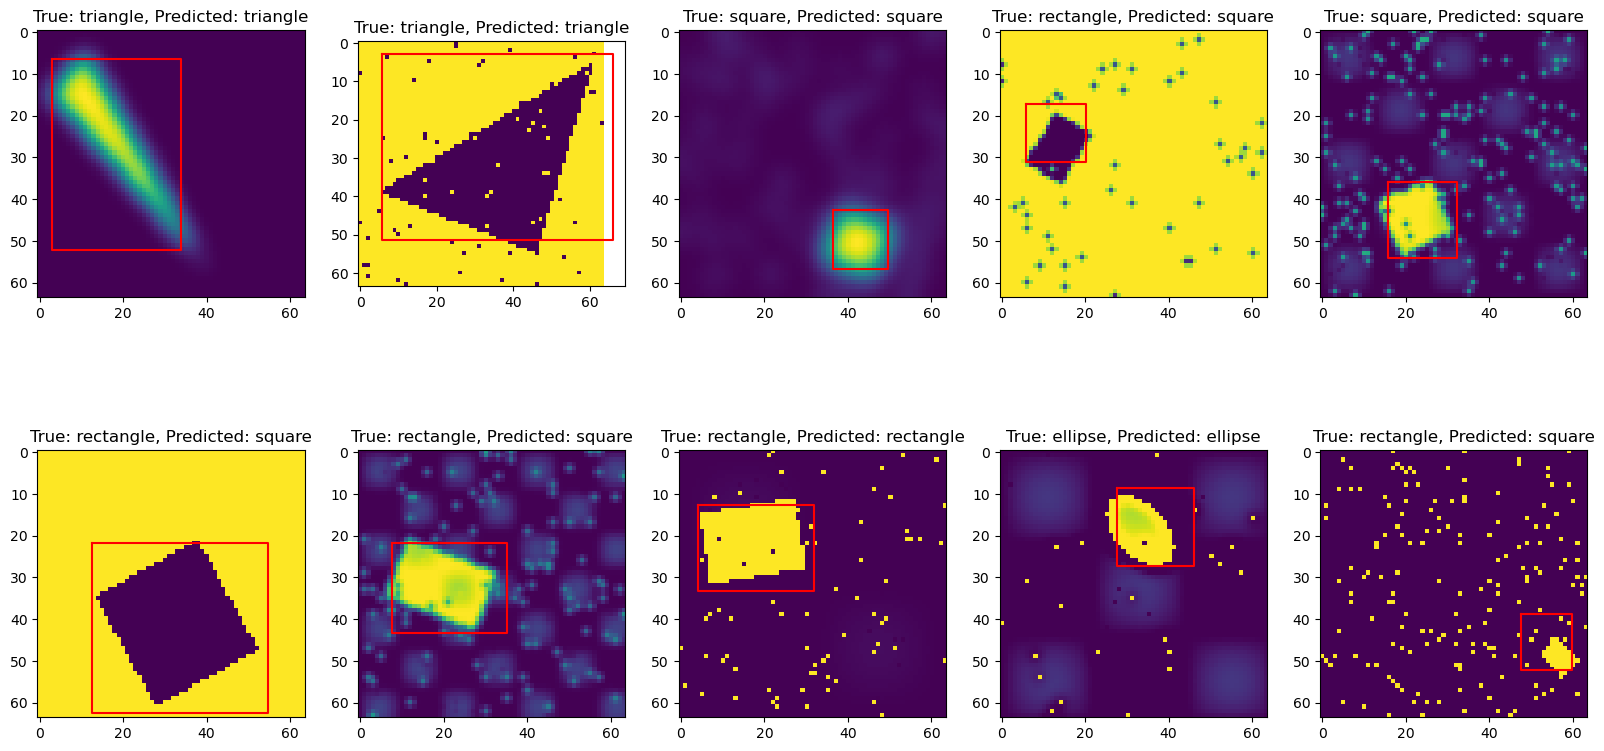

In [99]:
fig, axes = plt.subplots(2,5,figsize=(20,10))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(stored_images[i][0])
    axes[i].set_title(f"True: {shapes[stored_labels[i].item()]}, Predicted: {shapes[np.argmax(stored_outputs[i])]}")
    #plot bbox
    bbox = stored_bbox[i]
    x1,y1,dx,dy = bbox*64
    vertices = [(x1,y1),(x1+dx,y1),(x1+dx,y1+dy),(x1,y1+dy),(x1,y1)]
    axes[i].plot([v[0] for v in vertices],[v[1] for v in vertices],color='red')

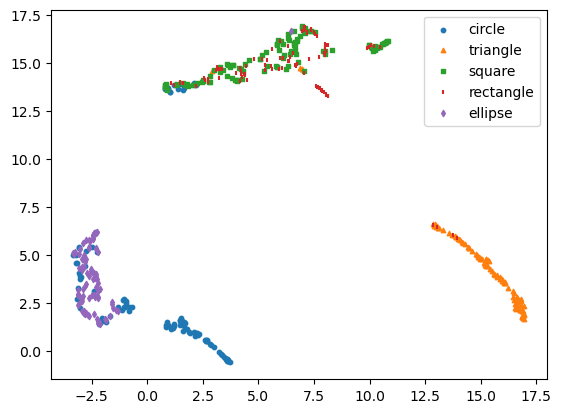

In [100]:
#umap
markers = {0:'o',1:'^',2:'s',3:'|',4:'d'}
reducer = umap.UMAP()
embedding = reducer.fit_transform(stored_intermediate)
fig,ax = plt.subplots()
for shape in range(5):
    ax.scatter(embedding[stored_labels==shape, 0], embedding[stored_labels==shape, 1], 
               label=shapes[shape], s=10,
                c='C'+str(shape),
               marker=markers[shape],
              )
plt.legend()

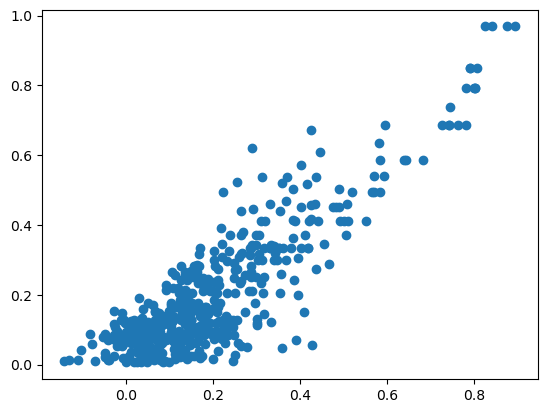

In [101]:
plt.scatter(predicted_sizes,stored_sizes)